# Validate Dynast's metabolic labeling quantification

This notebook will validate the metabolic labeling quantification (labeled, unlabeled transcripts) produced by Dynast with that produced by the [scNT-seq pipeline](https://github.com/wulabupenn/scNT-seq). Note that several changes were necessary to the scNT-seq pipeline due to inherent bugs and outdated dependencies. The version used for this study can be found [here](https://github.com/Lioscro/scNT-seq).

In [107]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import dynamo as dyn
    
import anndata
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score

plt.style.use('default')
plt.style.use('../figures.mplstyle')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

In [2]:
with open('data/accessions.txt', 'r') as f:
    accessions = [line.strip() for line in f]
sample_accessions = accessions[1:]

gene_list = pd.read_csv('data/0408_grp_info.txt', sep='\t')
# Some genes have been renamed in this reference.
gene_list.rename({
    'Gltscr2': 'Nop53',
    'A830010M20Rik': 'Btbd8'
}, inplace=True)

cell_list = pd.read_csv('data/cells.csv', names=['time', 'barcode'])

accession_times = {
    'SRR11683967': 0,
    'SRR11683968': 15,
    'SRR11683969': 30,
    'SRR11683970': 60,
    'SRR11683971': 120
}
dynast_adatas = {}
scNT_adatas = {}
for accession in sample_accessions:
    scNT_adata = anndata.read(f'scNT/{accession}/adata/adata.h5ad')
    dynast_adata = anndata.read(f'dynast/{accession}/count/adata.h5ad')
    
    # Make sure both have the same cells and genes
    barcodes = np.intersect1d(scNT_adata.obs_names, dynast_adata.obs_names)
    barcodes = sorted(np.intersect1d(barcodes, cell_list[cell_list['time'] == accession_times[accession]]['barcode']))
    genes = sorted(np.intersect1d(scNT_adata.var_names, dynast_adata.var_names))

    scNT_adatas[accession] = scNT_adata[barcodes, genes].copy()
    dynast_adatas[accession] = dynast_adata[barcodes, genes].copy()

## Comparisons

Compare the labeled, unlabeled counts between the two pipelines.

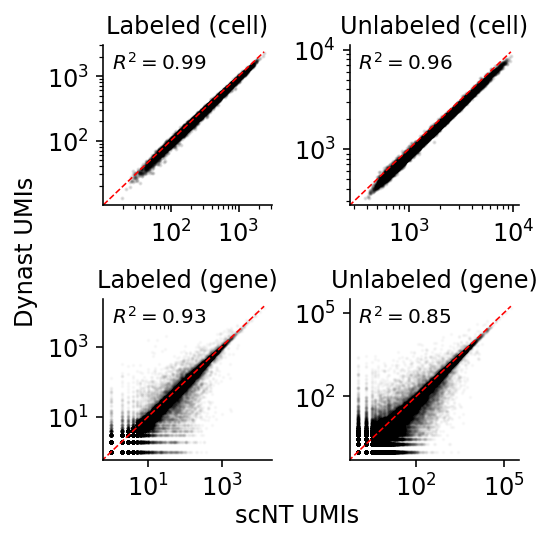

In [154]:
def plot_correlation(x, y, alpha, ax):
    r2 = r2_score(np.log1p(x), np.log1p(y))
    
    ax.scatter(x, y, s=1, c='black', alpha=alpha)
    high = max(max(x), max(y))
    ax.plot([0, high], [0, high], c='red', linestyle='--', linewidth=0.8)
    ax.text(0.05, 0.85, f'$R^2 = {r2:.2f}$', fontsize=10, transform=ax.transAxes)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    xlow, xhigh = ax.get_xlim()
    ylow, yhigh = ax.get_ylim()
    lim_low = min(xlow, ylow)
    lim_high = max(xhigh, yhigh)
    ax.set_xlim(lim_low, lim_high)
    ax.set_ylim(lim_low, lim_high)

scNT_cell_labeled = []
scNT_cell_unlabeled = []
dynast_cell_labeled = []
dynast_cell_unlabeled = []

scNT_gene_labeled = []
scNT_gene_unlabeled = []
dynast_gene_labeled = []
dynast_gene_unlabeled = []
for accession in sample_accessions:
    scNT_adata = scNT_adatas[accession]
    dynast_adata = dynast_adatas[accession]
    
    scNT_cell_labeled.extend(scNT_adata.layers['labeled_TC'].sum(axis=1).A.flatten())
    dynast_cell_labeled.extend(dynast_adata.layers['X_l_TC'].sum(axis=1).A.flatten())
    
    scNT_cell_unlabeled.extend(scNT_adata.layers['unlabeled_TC'].sum(axis=1).A.flatten())
    dynast_cell_unlabeled.extend(dynast_adata.layers['X_n_TC'].sum(axis=1).A.flatten())
    
    scNT_gene_labeled.extend(scNT_adata.layers['labeled_TC'].sum(axis=0).A.flatten())
    dynast_gene_labeled.extend(dynast_adata.layers['X_l_TC'].sum(axis=0).A.flatten())
    
    scNT_gene_unlabeled.extend(scNT_adata.layers['unlabeled_TC'].sum(axis=0).A.flatten())
    dynast_gene_unlabeled.extend(dynast_adata.layers['X_n_TC'].sum(axis=0).A.flatten())
    
fig, axes = plt.subplots(figsize=(4, 4), ncols=2, nrows=2, tight_layout=True)
plot_correlation(scNT_cell_labeled, dynast_cell_labeled, 0.1, axes[0,0])
axes[0, 0].set_title('Labeled (cell)')

plot_correlation(scNT_cell_unlabeled, dynast_cell_unlabeled, 0.1, axes[0,1])
axes[0, 1].set_title('Unlabeled (cell)')

plot_correlation(scNT_gene_labeled, dynast_gene_labeled, 0.02, axes[1,0])
axes[1, 0].set_title('Labeled (gene)')
axes[1, 0].set_xticks([10, 1000])

plot_correlation(scNT_gene_unlabeled, dynast_gene_unlabeled, 0.02, axes[1,1])
axes[1, 1].set_title('Unlabeled (gene)')
axes[1, 1].set_xticks([100, 100000])

fig.supylabel('Dynast UMIs', x=0.06, y=0.55)
fig.supxlabel('scNT UMIs', y=0.07, x=0.55)
fig.savefig('figures/scNT_umis.pdf', bbox_inches='tight')
fig.savefig('figures/scNT_umis.png', bbox_inches='tight', dpi=300)

NTR correlation

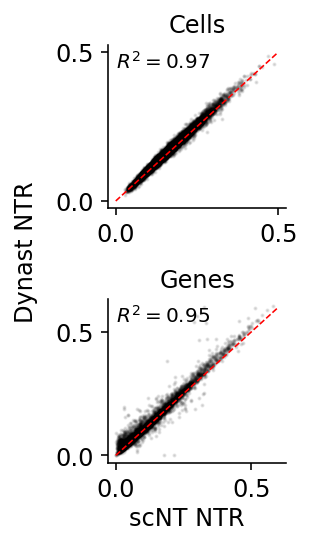

In [158]:
def plot_ntr_correlation(x, y, high, ax):
    r2 = r2_score(x, y)
    
    ax.scatter(x, y, s=1, c='black', alpha=0.1)
    ax.plot([0, high], [0, high], c='red', linestyle='--', linewidth=0.8)
    ax.set_xticks([0.0, 0.5])
    ax.set_yticks([0.0, 0.5])
    ax.text(0, ax.get_ylim()[1] * 0.85, f'$R^2 = {r2:.2f}$', fontsize=10)

scNT_cell_ntrs = []
dynast_cell_ntrs = []
scNT_gene_ntrs = []
dynast_gene_ntrs = []

for accession in sample_accessions:
    scNT_adata = scNT_adatas[accession].copy()
    dynast_adata = dynast_adatas[accession].copy()
    
    scNT_cell_ntr = scNT_adata.layers['labeled_TC'].sum(axis=1).A.flatten() / scNT_adata.X.sum(axis=1).A.flatten()
    dynast_cell_ntr = dynast_adata.layers['X_l_TC'].sum(axis=1).A.flatten() / dynast_adata.X.sum(axis=1).A.flatten()
    scNT_cell_ntrs.extend(scNT_cell_ntr)
    dynast_cell_ntrs.extend(dynast_cell_ntr)
    
    genes = scNT_adata.X.sum(axis=0).A.flatten().argsort()[-1000:]
    scNT_adata = scNT_adata[:, genes].copy()
    dynast_adata = dynast_adata[:, genes].copy()
    
    scNT_gene_sum = scNT_adata.X.sum(axis=0).A.flatten()
    dynast_gene_sum = dynast_adata.X.sum(axis=0).A.flatten()
    gene_mask = (scNT_gene_sum > 0) & (dynast_gene_sum > 0)
    scNT_adata = scNT_adata[:,gene_mask].copy()
    dynast_adata = dynast_adata[:, gene_mask].copy()
    
    scNT_gene_ntr = scNT_adata.layers['labeled_TC'].sum(axis=0).A.flatten() / scNT_adata.X.sum(axis=0).A.flatten()
    dynast_gene_ntr = dynast_adata.layers['X_l_TC'].sum(axis=0).A.flatten() / dynast_adata.X.sum(axis=0).A.flatten()
    
    scNT_gene_ntrs.extend(scNT_gene_ntr)
    dynast_gene_ntrs.extend(dynast_gene_ntr)

fig, axes = plt.subplots(figsize=(2.3, 4), nrows=2, tight_layout=True)
plot_ntr_correlation(scNT_cell_ntrs, dynast_cell_ntrs, 0.5, axes[0])
axes[0].set_title('Cells')
plot_ntr_correlation(scNT_gene_ntrs, dynast_gene_ntrs, 0.6, axes[1])
axes[1].set_title('Genes')

fig.supxlabel('scNT NTR', y=0.065, x=0.6)
fig.supylabel('Dynast NTR', x=0.08, y=0.55)
fig.savefig('figures/scNT_ntr.pdf', bbox_inches='tight')
fig.savefig('figures/scNT_ntr.png', bbox_inches='tight', dpi=300)

## RNA velocity

Generate RNA velocity flows similar to that was done in the scNT-seq paper [Figure 3](https://www.nature.com/articles/s41592-020-0935-4/figures/3).

We will use a subset of neural activity genes (identified in [Extended Data Fig. 2.d](https://www.nature.com/articles/s41592-020-0935-4/figures/8)).

In [63]:
scNT_adata = anndata.AnnData.concatenate(
    *list(scNT_adatas.values()), batch_key='accession', batch_categories=scNT_adatas.keys()
)
dynast_adata = anndata.AnnData.concatenate(
    *list(dynast_adatas.values()), batch_key='accession', batch_categories=dynast_adatas.keys()
)

# Activation time, as a category for better colors
scNT_adata.obs['activation_time'] = scNT_adata.obs['accession'].map(accession_times).astype(int)
dynast_adata.obs['activation_time'] = dynast_adata.obs['accession'].map(accession_times).astype(int)

# Labeling time in hours
scNT_adata.obs['labeling_time'] = 2
dynast_adata.obs['labeling_time'] = 2

# Rename layers for Dynamo
scNT_adata.layers['new'] = scNT_adata.layers['labeled_TC'].copy()
scNT_adata.layers['total'] = scNT_adata.X.copy()
for layer in list(scNT_adata.layers.keys()):
    if layer not in ('new', 'total'):
        del scNT_adata.layers[layer]
dynast_adata.layers['new'] = dynast_adata.layers['X_l_TC'].copy()
dynast_adata.layers['total'] = dynast_adata.X.copy()
for layer in list(dynast_adata.layers.keys()):
    if layer not in ('new', 'total'):
        del dynast_adata.layers[layer]
        
# Subset genes
scNT_adata = scNT_adata[:, gene_list.index].copy()
dynast_adata = dynast_adata[:, gene_list.index].copy()

def dynamo_workflow(adata):
    dyn.pp.recipe_monocle(adata, tkey='labeling_time')
    dyn.tl.dynamics(adata, NTR_vel=True)
    dyn.tl.reduceDimension(adata)
    dyn.tl.cell_velocities(adata, calc_rnd_vel=True)
    dyn.vf.VectorField(adata, basis='umap')
    
dynamo_workflow(scNT_adata)
dynamo_workflow(dynast_adata)

|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----> 
Dynamo detects your labelin

estimating gamma: 100%|██████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:08<00:00, 11.82it/s]
/home/kmin/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [53.4249s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

/home/kmin/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [6.1898s]
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [17.7693s]


/home/kmin/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [6.8786s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [25.0086s]
|-----------> current cosine correlation between input velocities and learned velocities is less than 0.6. Make a 1-th vector field reconstruction trial.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [22.5250s]
|-----------> current cosine corre

estimating gamma: 100%|██████████████████████████████████████████████████████████████████████████████████████| 97/97 [00:08<00:00, 11.12it/s]
/home/kmin/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [54.9671s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|

/home/kmin/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [7.1411s]
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [18.4291s]


/home/kmin/miniconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [6.9444s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [31.9172s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.
|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-

|-----------> plotting with basis key=X_umap
|-----------> plotting with basis key=X_umap


/tmp/ipykernel_26794/908619726.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('figures/scNT_velocity.pdf', bbox_inches='tight')
/tmp/ipykernel_26794/908619726.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('figures/scNT_velocity.png', bbox_inches='tight', dpi=300)
/home/kmin/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


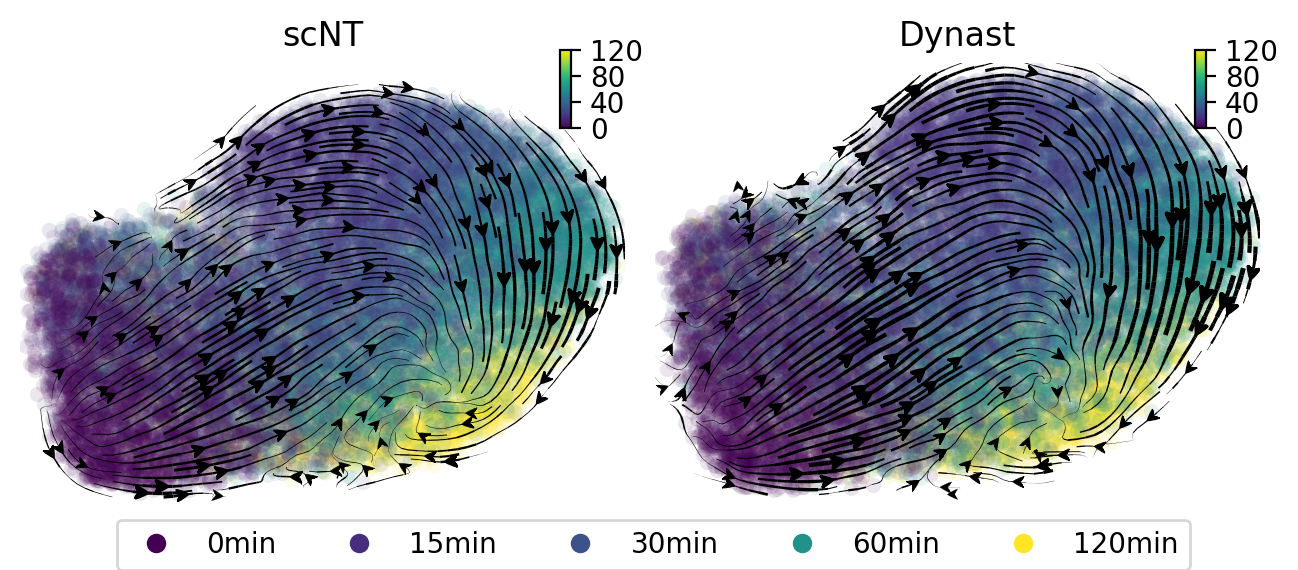

In [120]:
cmap = plt.get_cmap('viridis')

def plot_velocity(adata, ax):
    for time in sorted(adata.obs['activation_time'].unique(), reverse=True):
        time_adata = adata[adata.obs['activation_time'] == time]
        ax.scatter(
            time_adata.obsm['X_umap'][:,0], time_adata.obsm['X_umap'][:,1],
            s=30, alpha=0.1, linewidth=0,
            c=mpl.colors.to_hex(cmap(time / adata.obs['activation_time'].max())),
            label=str(time)
        )
    dyn.pl.streamline_plot(
        adata,
        color='activation_time',
        color_key_cmap = 'viridis',
        basis='umap',
        show_legend='right',
        save_show_or_return='return',
        s_kwargs_dict=dict(s=0),
        ax=ax
    )

fig, axes = plt.subplots(figsize=(6.5, 2.8), ncols=2, tight_layout=True)
plot_velocity(scNT_adata, axes[0])
axes[0].set_title('scNT')
plot_velocity(dynast_adata, axes[1])
axes[1].set_title('Dynast')

fig.legend(handles=[
    Line2D(
        [0], [0],
        marker='o', lw=0,
        color=cmap(time / scNT_adata.obs['activation_time'].max()), label=f'{time}min'
    )
    for time in sorted(scNT_adata.obs['activation_time'].unique())
], loc=(0.09, 0), ncol=5)

fig.savefig('figures/scNT_velocity.pdf', bbox_inches='tight')
fig.savefig('figures/scNT_velocity.png', bbox_inches='tight', dpi=300)